In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
%matplotlib inline

In [2]:
#Loading Bank Dataset
bank = pd.read_csv('/Users/Bunny/Documents/Prasanthi/Springboard/Projects/Capstone 1 /Bank Marketing dataset/bank-additional/bank-additional-full.csv', delimiter=';')

In [3]:
#Data at a glance
bank.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
#Variables present in the dataset
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [5]:
#Dataset dimensions
bank.shape

(41188, 21)

In [6]:
#Renaming Dependent Variable 'y' as 'outcome' and 'campaign' as 'number_calls'
bank = bank.rename(columns= {'y':'outcome','campaign' : 'number_calls'})
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'number_calls', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'outcome'],
      dtype='object')

## Data Wrangling & Exploratory Data Analysis

### Missing value treatment

In [7]:
#Replacing unknown values with np.NaN
bank = bank.replace('unknown', np.NaN)

In [8]:
# % missing values for each attribute
bank.isnull().sum()/len(bank)*100 

age                0.000000
job                0.801204
marital            0.194231
education          4.202680
default           20.872584
housing            2.403613
loan               2.403613
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
number_calls       0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
outcome            0.000000
dtype: float64

### Transforming Dependent variable - 'outcome'

In [9]:
#Converting dependent variable'outcome' from categorical to numerical. yes = 1 , no = 0
bank['outcome'] = (bank['outcome']=='yes').astype(int)

#### Investigating variables with > 2% missing values

#### 1) Default

In [10]:
#Investigating 'default' variable 
bank.groupby(['outcome', 'default']).size().unstack('default')

default,no,yes
outcome,,
0,28391.0,3.0
1,4197.0,NaN


* According to this, only 3 customers with credit defaults have been contacted and the remaining contacted were those with either no credit amounts or with cleared monthly payments. This attribute will therefore be of no use for predicting the outcome and hence will be removed.

In [11]:
#remove 'default' variable from the dataset
bank = bank.drop('default',axis=1)

#### 2) Loan

In [12]:
bank['loan'].unique()

array(['no', 'yes', nan], dtype=object)

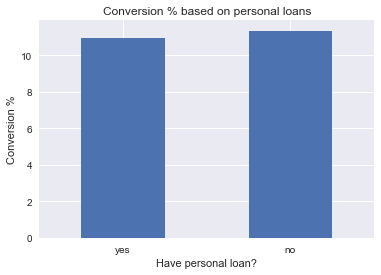

In [13]:
loan_conv = bank.groupby('outcome').loan.value_counts().unstack('outcome')
loan_conv['conversion_rate']= 100*loan_conv[1]/(loan_conv[0]+loan_conv[1])
loan_conv['conversion_rate'].sort_values().plot(kind= 'bar', title = 'Conversion % based on personal loans',rot=360)
plt.ylabel('Conversion %')
plt.xlabel('Have personal loan?')

The above graph represents how customers having prior loans have reacted towards the campaign compared to those who didn't and we can see that the conversion rates for both categories are similar.

In [14]:
#Chi-Square test to check existence of statistical difference among customers with orior loans and those without loans
outcome_loan = bank.groupby(['outcome', 'loan']).size().unstack('loan')
outcome_loan

loan,no,yes
outcome,,
0,30100,5565
1,3850,683


In [15]:
#Returns chi2, p-value, Degrees of freedom, contingency_table
contingency_table_loan = chi2_contingency(outcome_loan)
contingency_table_loan

(0.84063933655186474,
 0.35921398426348206,
 1,
 array([[ 30121.56699338,   5543.43300662],
        [  3828.43300662,    704.56699338]]))

Chi-square test showed a p-value > 0.05 and chi-cal>chi-tab which shows that there is statistically no significant difference in outcome between the two groups and hence this variable is being dropped form further analysis.

In [16]:
#Remove 'loan' variable from the dataset
bank = bank.drop('loan',axis=1)

#### 3) Housing (loan)

In [17]:
bank['housing'].unique()

array(['no', 'yes', nan], dtype=object)

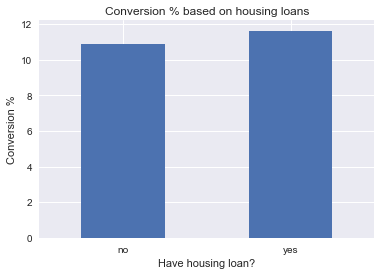

In [18]:
housing_conv = bank.groupby('outcome').housing.value_counts().unstack('outcome')
housing_conv['conversion_rate']= 100*housing_conv[1]/(housing_conv[0]+housing_conv[1])
housing_conv['conversion_rate'].sort_values().plot(kind= 'bar', title = 'Conversion % based on housing loans',rot=360)
plt.ylabel('Conversion %')
plt.xlabel('Have housing loan?')

In the case of customers with/without housing loan, based on above graph results, there does not seem to be any difference between the two groups.

In [20]:
#Chi-Square test to check existence of statistical difference among customers with existing housing loan 
#and those without it
outcome_housing = bank.groupby(['outcome', 'housing']).size().unstack('housing')
outcome_housing

housing,no,yes
outcome,,
0,16596,19069
1,2026,2507


In [21]:
#Returns chi2, p-value, Degrees of freedom, contingency_table
contingency_table_housing = chi2_contingency(outcome_housing)
contingency_table_housing

(5.3937900445262397,
 0.02020853196455713,
 1,
 array([[ 16522.05656998,  19142.94343002],
        [  2099.94343002,   2433.05656998]]))

However, results of chi-square have suggested that there is a statistically significant difference in outcome between the two groups and hence this variable will be retained for further analysis.

#### 4) Education

In [22]:
#Combining all basic education into one category 'basic'
bank['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', nan, 'university.degree', 'illiterate'], dtype=object)

In [23]:
bank['education']=np.where(bank['education']=='basic.4y','basic',bank['education'])
bank['education']=np.where(bank['education']=='basic.6y','basic',bank['education'])
bank['education']=np.where(bank['education']=='basic.9y','basic',bank['education'])

outcome,0,1,conversion_rate
education,,,
basic,11424,1089,8.702949
high.school,8484,1031,10.835523
illiterate,14,4,22.222222
professional.course,4648,595,11.348465
university.degree,10498,1670,13.724523


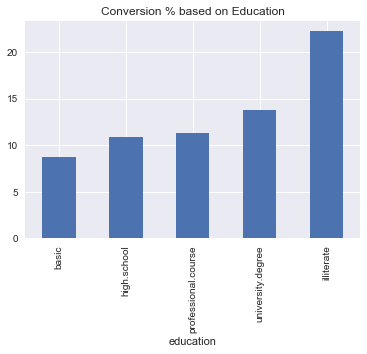

In [24]:
education_conv = bank.groupby('outcome').education.value_counts().unstack('outcome')
education_conv['conversion_rate']= 100*education_conv[1]/(education_conv[0]+education_conv[1])
education_conv['conversion_rate'].sort_values().plot(kind= 'bar', title = 'Conversion % based on Education')
education_conv

Similar conversion rates have been observed across all education categories other than illiterate category. However, sample size of this category is negligible compared to that of customers with some kind of education background. 

In [25]:
#Removing rows containing null values
bank = bank.dropna(axis = 0)

## Exploratory Data Analysis

#### Summary stats

In [26]:
#Summary statistics of Continuous varibles
bank.describe()

,age,duration,number_calls,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,outcome
count,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000
mean,39.860871,258.207583,2.566662,963.531651,0.170009,0.082861,93.570313,-40.541164,3.623298,5167.432566,0.111335
std,10.289488,259.792638,2.767473,184.295254,0.487169,1.565945,0.576367,4.623200,1.730226,71.760333,0.314550
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


Average age of customers contacted for this campaign is 39 years and each customer was contacted approx. 3 times before hearing a decision from them.

#### Distribution of Dependent variable categories

outcome
0    88.866518
1    11.133482
dtype: float64


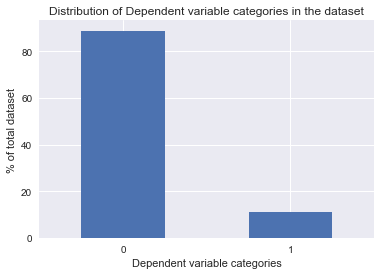

In [27]:
#Distribution of 'outcome' variable
bank_outcome_dist = bank.groupby('outcome').size()/len(bank)*100
print(bank_outcome_dist)
bank_outcome_dist.plot(kind = 'bar',rot=360)
plt.xlabel('Dependent variable categories')
plt.ylabel('% of total dataset')
plt.title('Distribution of Dependent variable categories in the dataset')

The bank marketing dataset in study is highly imbalanced. Unfavourable outcomes make upto about 89% of the total observations while the favourable ones make up the remaining 11% making the data vulnerable to prediction biases while trying to fit machine-learning models. We will be dealing with this issue only after performing EDA in order to understand the dynamics of unmanipulated data better.

#### Independent Variable - 'Duration'

* The variable ‘duration’ highly affects the output target; i.e. if a call has not been made at all or not been picked by the customer it results in a failed outcome. Yet, the duration is not known before a call is performed. Also, after the end of the call outcome is obviously known (success or a failure). Hence this variable has been removed from future analysis. 

In [28]:
#Remove 'duration' variable from the dataset
bank = bank.drop('duration',axis=1)

#### Variable number_calls - Average calls made per customer based on 'outcome' categories

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1126ca6a0>], dtype=object)

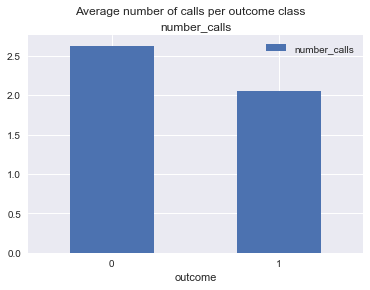

In [29]:
# Average number of calls per outcome class
bank[['number_calls','outcome']].groupby(['outcome']).mean().plot(kind='bar',subplots=True,rot=360,title= 'Average number of calls per outcome class') 

In [30]:
campaign_calls = (bank['number_calls'] <= 3).sum()*100/ len(bank)
print('% of customers contacted 3 or less than 3 times:',campaign_calls,('%'))
print('% of customers contacted more than 3 times:', (100-campaign_calls),('%'))

% of customers contacted 3 or less than 3 times: 81.4459406458 %
% of customers contacted more than 3 times: 18.5540593542 %


Customers on an average made their decision by 3rd call with a bank representative. Those who agreed to the offer made their decision within the 2nd call. Customers who rejected the offer expressed their lack of interest only at 3rd call or later. 

For the purpose of modelling, the overall average calls aspect of this attribute was used and individual outcome wise data has been ignored. 

#### Age variable

In [31]:
#Changing age variable into an integer in order to create categories
bank['age'].astype(int)
bank['age'].dtypes

dtype('int64')

In [32]:
#Converting Age variable to a categorical variable 'age_category'
bank['age_category']=np.where(bank['age'] < 25,'Young adult',bank['age'])
bank['age_category']=np.where((bank['age'] >= 25) & (bank['age'] < 35 ),'Adult',bank['age_category'])
bank['age_category']=np.where((bank['age'] >= 35) & (bank['age'] < 54 ),'Middle Aged',bank['age_category'])
bank['age_category']=np.where((bank['age'] >= 54) & (bank['age'] < 60 ),'Pre-retirement',bank['age_category'])
bank['age_category']=np.where((bank['age'] >= 60),'Post-retirement',bank['age_category'])

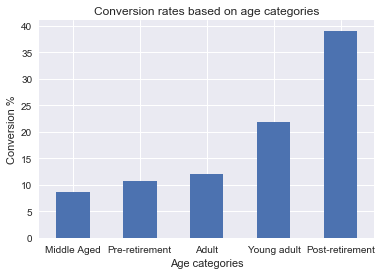

In [33]:
#Conversion rates based on Age categories 
age = bank.groupby('outcome').age_category.value_counts().unstack('outcome')
age['conversion_rates'] = (age[1]/(age[0]+age[1]))*100
age['conversion_rates'].sort_values().plot(kind='bar',title='Conversion rates based on age categories',rot=360)
plt.ylabel('Conversion %')
plt.xlabel('Age categories')

Based on the above graph, Retired individuals and young adults seem to be interested in term-deposit offer. These could be highly potential groups while rolling out term-deposit campaigns in future. 

Since the remaining 3 groups have similar coversion rates, we can put bucket them into 1 category called 'Working adults' which describes them the best; Adults to pre-retirement.

In [34]:
bank['age_category']=np.where((bank['age'] >= 25) & (bank['age'] < 60 ),'Working adult',bank['age_category'])


Chi-square test has been performed to see if there is any statistically significant difference in campaign outcome among these groups.

In [35]:
#Chi-Square test to check existence of statistical difference among Age groups
outcome_age = bank.groupby(['outcome', 'age_category']).size().unstack('age_category')
outcome_age

age_category,Post-retirement,Working adult,Young adult
outcome,,,
0,625,32635,727
1,401,3653,204


In [36]:
#Returns chi2, p-value, Degrees of freedom, contingency_table
contingency_table = chi2_contingency(outcome_age)
contingency_table

(961.18396178281444,
 1.9122939538170554e-209,
 2,
 array([[   911.7704798 ,  32247.88223297,    827.34728723],
        [   114.2295202 ,   4040.11776703,    103.65271277]]))

Chi-tabular < Chi-calculated with a p-value <0.05 indicates that there is a statistically significant difference in outcome based on different categories of age. 

#### Job 

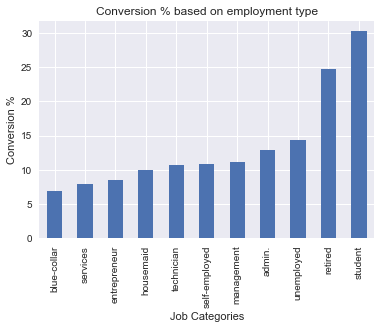

In [37]:
#Conversion rates based on Job Categories
job = bank.groupby('outcome').job.value_counts().unstack('outcome')
job['conversion_rate']= 100*job[1]/(job[0]+job[1])
job['conversion_rate'].sort_values().plot(kind= 'bar', title = 'Conversion % based on employment type',rot = 90)
plt.ylabel('Conversion %')
plt.xlabel('Job Categories')

Individuals who are retired, are students, unemployed or have administrative roles have higher conversion rates compared to those working in other roles.

Retired individuals do not draw regular incomes. Their main interest would be to invest all the savings that have been accumulated so far into low-risk safe return generating products such as term deposits. Also, the average age of retired individuals is 62 which supports the analysis derived from age variable. 

Students do not have a consistent source of income and are most likely to look for avenues that can grow their savings without having inherent risks until they reach their prime earning period. Blue-collar, housemaids and technicians have very low disposable incomes and tend to have minimum to no savings for them to be able to invest.

On the other hand, risk taking, whether financial or social is a distinguishing characteristic of entrepreneurs. High-risk avenues like stocks and other equity based instruments are more rewarding for them than term deposits.

It is interesting to see unemployed in the high conversion category. External data can be combined in future to arrive at a consensus.

In [38]:
print('The mean age of retired individuals is:', round(bank[bank.job == 'retired'].age.mean()),'yrs')

The mean age of retired individuals is: 62 yrs


In [39]:
print('The mean age of student category is:', round(bank[bank.job == 'student'].age.mean()),'yrs')

The mean age of student category is: 26 yrs


Mean age of the top two categories has been calculated to see if the results support what has been observed while analyzing the Age category and there indeed do. Young adults represent 25 yrs age group and retired individuals represent individuals aged 60 yrs and more.

#### Months of an year

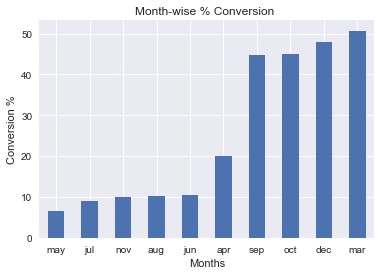

In [40]:
#Conversion rates based on different Months of an year
month_wise = bank.groupby('outcome').month.value_counts().unstack('outcome')
month_wise['conversion_rate']= 100*month_wise[1]/(month_wise[0]+month_wise[1])
month_wise['conversion_rate'].sort_values().plot(kind= 'bar', title = 'Month-wise % Conversion ',rot =360)
plt.ylabel('Conversion %')
plt.xlabel('Months')

The Portuguese tax year runs concurrently with the calendar year from 1 January to 31 December. Individuals hold liquid cash until year-end in anticipation of unexpected expenditures over the course of that year. 

While locking funds in low-return investments such as term deposits in initial months itself might not be a good decision, year-end could be a good time to invest in them in order maximize tax benefits.

Data ranges from May 2008 to Nov 2010, thus reducing the possibility of random occurrences to a good extent.



#### Marital Status

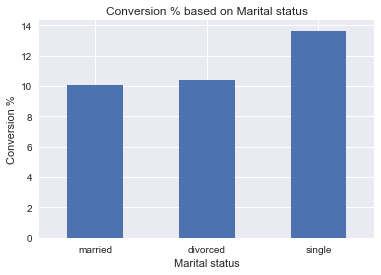

In [41]:
#Conversion rates based on marital status
marital_status = bank.groupby('outcome').marital.value_counts().unstack('outcome')
marital_status['conversion_rate']= 100*marital_status[1]/(marital_status[0]+marital_status[1])
marital_status['conversion_rate'].sort_values().plot(kind= 'bar', title = 'Conversion % based on Marital status',rot = 360)
plt.ylabel('Conversion %')
plt.xlabel('Marital status')

Not much difference can be observed in conversion rates based on martital status categories in this preliminary analysis.

In [42]:
#Chi-Square test to check existence of statistical difference among Age groups
outcome_marital = bank.groupby(['outcome', 'marital']).size().unstack('marital')
outcome_marital

marital,divorced,married,single
outcome,,,
0,3854,20842,9291
1,448,2341,1469


In [43]:
#Returns chi2, p-value, Degrees of freedom, contingency_table
contingency_table_marital = chi2_contingency(outcome_marital)
contingency_table_marital

(96.384585038939349,
 1.1758536958018105e-21,
 2,
 array([[  3823.03762583,  20601.92498366,   9562.03739051],
        [   478.96237417,   2581.07501634,   1197.96260949]]))

Chi-tabular < Chi-calculated with a p-value <0.05 indicates that there is a statistically significant difference in outcome based on marital status and hence this variable will be retained for future analysis.

#### Contact

In [44]:
bank['contact'].unique()

array(['telephone', 'cellular'], dtype=object)

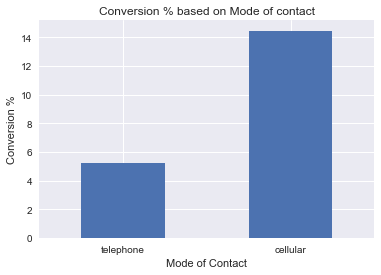

In [45]:
contact_conv = bank.groupby('outcome').contact.value_counts().unstack('outcome')
contact_conv['conversion_rate']= 100*contact_conv[1]/(contact_conv[0]+contact_conv[1])
contact_conv['conversion_rate'].sort_values().plot(kind= 'bar', title = 'Conversion % based on Mode of contact',rot=360)
plt.ylabel('Conversion %')
plt.xlabel('Mode of Contact')


It has been observed that the conversion rate for customers contacted via mobile phones is 3 times higher than those contacted through landlines. Mobile bank transactions are slowly gaining popularity among individuals with varying socio-economic backgrounds due to comfort and ease of operation and this would provide banks with customer's mobile information.

This shift could directly impact outcomes of marketing campaigns in study and thereby improving campaign profits to a great extend; based on above observation if everything else remains constant, just by contacting all customers via mobiles could increase profits by 3 times. 

#### pdays
    Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

In [46]:
bank['pdays'].value_counts()

999    36879
3        393
6        379
4        106
2         57
9         55
12        53
7         52
5         45
10        44
13        33
11        26
1         24
15        22
14        18
0         15
8         14
16         8
17         6
18         5
19         3
22         3
21         2
26         1
25         1
27         1
Name: pdays, dtype: int64

A huge majority of customers have not been contacted for any marketing campaigns in the past. This variable will not help in predicting outcome of the campaign and therefore will be dropped for futher analysis. 

In [47]:
bank = bank.drop('pdays', axis =1)

#### poutcome

In [48]:
bank['poutcome'].value_counts()

nonexistent    33066
failure         3936
success         1243
Name: poutcome, dtype: int64

Previous campaign outcome in non existent for 90% of the customers.This variable will not add any value while trying to predict current campaigns outcome and hence will be dropped from further analysis.

In [49]:
bank = bank.drop('poutcome',axis=1)

#### previous

In [50]:
bank['previous'].value_counts()

0    33066
1     4234
2      672
3      195
4       57
5       16
6        4
7        1
Name: previous, dtype: int64

This variable is same as poutcome. It is the number of contacts performed before this campaign and for this client. This variable shall be dropped as well. 

In [51]:
bank = bank.drop('previous', axis =1)

###  Normalizing dataset

In [52]:
bank_continuous = bank[['number_calls','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']]

In [53]:
#Normalizing dataset
for columns in bank_continuous:
    bank[columns] = (bank[columns]-np.mean(bank[columns]))/(np.std(bank[columns]))
    columns = range(bank_continuous.shape[1])

In [54]:
bank.describe()

,age,number_calls,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,outcome
count,38245.000000,3.824500e+04,3.824500e+04,3.824500e+04,3.824500e+04,3.824500e+04,3.824500e+04,38245.000000
mean,39.860871,-2.173384e-14,-2.545412e-13,-6.738102e-11,-2.248749e-12,1.685190e-13,5.018674e-11,0.111335
std,10.289488,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,0.314550
min,17.000000,-5.661058e-01,-2.224156e+00,-2.375799e+00,-2.219019e+00,-1.727715e+00,-2.840500e+00,0.000000
25%,32.000000,-5.661058e-01,-1.202396e+00,-8.593829e-01,-4.669633e-01,-1.317359e+00,-9.522456e-01,0.000000
50%,38.000000,-2.047607e-01,6.495457e-01,-2.191571e-01,-2.722904e-01,7.130388e-01,3.284230e-01,0.000000
75%,47.000000,1.565845e-01,8.411259e-01,7.351090e-01,8.957470e-01,7.731473e-01,8.454285e-01,0.000000
max,98.000000,1.461039e+01,8.411259e-01,2.076287e+00,2.950627e+00,8.216965e-01,8.454285e-01,1.000000


##  Check for Multi-collinearity 

In [55]:
bank.corr() > 0.5

,age,number_calls,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,outcome
age,True,False,False,False,False,False,False,False
number_calls,False,True,False,False,False,False,False,False
emp.var.rate,False,False,True,True,False,True,True,False
cons.price.idx,False,False,True,True,False,True,True,False
cons.conf.idx,False,False,False,False,True,False,False,False
euribor3m,False,False,True,True,False,True,True,False
nr.employed,False,False,True,True,False,True,True,False
outcome,False,False,False,False,False,False,False,True


High collinearity exists among the following macro-econimic factors:
- Employee Variable rate, Consumer Price Index, Euribor 3m rate and number employed.

## PCA to eliminate multi collinearity

In [56]:
#bank subset containing macro-economic factors
bank_pca = bank[['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']]
bank_pca

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.649546,0.735109,0.895747,0.713039,0.328423
1,0.649546,0.735109,0.895747,0.713039,0.328423
2,0.649546,0.735109,0.895747,0.713039,0.328423
3,0.649546,0.735109,0.895747,0.713039,0.328423
4,0.649546,0.735109,0.895747,0.713039,0.328423
5,0.649546,0.735109,0.895747,0.713039,0.328423
6,0.649546,0.735109,0.895747,0.713039,0.328423
8,0.649546,0.735109,0.895747,0.713039,0.328423
9,0.649546,0.735109,0.895747,0.713039,0.328423
11,0.649546,0.735109,0.895747,0.713039,0.328423


In [57]:
# Importing PCA algorithmn from library
from sklearn.decomposition import PCA

In [58]:
# Fitting PCA model onto macro-economic features
pca = PCA()
pca.fit(bank_pca)

# Explained variance from each of the pca components
print(pca.explained_variance_ratio_) 

[ 0.69623218  0.19507041  0.10152953  0.00501144  0.00215644]


In [60]:
#Preparing data for Scree Plot
x_df = pd.DataFrame(columns=['Eigen Values','Number of Eigen Values'])

In [61]:
x_df['Eigen Values'] = (pca.explained_variance_ratio_)*100
x_df['Number of Eigen Values']= range(1, 6, 1)
x_df.rename(columns={'Eigen Values':'Explained variance %'})

,Explained variance %,Number of Eigen Values
0,69.623218,1
1,19.507041,2
2,10.152953,3
3,0.501144,4
4,0.215644,5


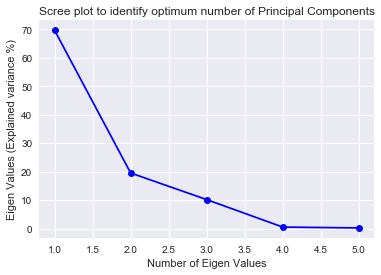

In [62]:
# Selecting optimum number of pca components using Scree Plot
x = x_df['Number of Eigen Values']
y = x_df['Eigen Values']
plt.plot(x,y,'bo-',label = "Scree Plot to determine value for number of PCA components")
plt.xlabel('Number of Eigen Values')
plt.ylabel('Eigen Values (Explained variance %)')
plt.title('Scree plot to identify optimum number of Principal Components')

For greater than 3 eigen values, the slope seems to flatten out i.e not much variance is explained by the remaining two components and hence 3 is an ideal pca number in this case. 

In [63]:
# Generating component array from macro-economic features
pca_array = pca.transform(bank_pca)
# Creating a dataframe with top 3 PCA components
bank_pca_df = pd.DataFrame(pca_array)
bank_pca_df= bank_pca_df.rename(columns={0:'PCA1',1:'PCA2',2:'PCA3',3:'PCA4',4:'PCA5'})
bank_pca_df= bank_pca_df.drop(['PCA4','PCA5'],axis =1)
bank_pca_df

,PCA1,PCA2,PCA3
0,-1.320113,0.688198,0.399483
1,-1.320113,0.688198,0.399483
2,-1.320113,0.688198,0.399483
3,-1.320113,0.688198,0.399483
4,-1.320113,0.688198,0.399483
5,-1.320113,0.688198,0.399483
6,-1.320113,0.688198,0.399483
7,-1.320113,0.688198,0.399483
8,-1.320113,0.688198,0.399483
9,-1.320113,0.688198,0.399483


In [64]:
# Dropping multi-collinear macro economic variabes from the dataset 
bank_final = bank.drop(['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'],axis =1)
# Resetting bank dataframe's index to make it suitable for merging purpose
bank_final.index = range(len(bank_final))
bank_final

,age,job,marital,education,housing,contact,month,day_of_week,number_calls,outcome,age_category
0,56,housemaid,married,basic,no,telephone,may,mon,-0.566106,0,Working adult
1,57,services,married,high.school,no,telephone,may,mon,-0.566106,0,Working adult
2,37,services,married,high.school,yes,telephone,may,mon,-0.566106,0,Working adult
3,40,admin.,married,basic,no,telephone,may,mon,-0.566106,0,Working adult
4,56,services,married,high.school,no,telephone,may,mon,-0.566106,0,Working adult
5,45,services,married,basic,no,telephone,may,mon,-0.566106,0,Working adult
6,59,admin.,married,professional.course,no,telephone,may,mon,-0.566106,0,Working adult
7,24,technician,single,professional.course,yes,telephone,may,mon,-0.566106,0,Young adult
8,25,services,single,high.school,yes,telephone,may,mon,-0.566106,0,Working adult
9,25,services,single,high.school,yes,telephone,may,mon,-0.566106,0,Working adult


In [65]:
# Merging macro-economic PCA components with remaining bank dataset
bank_final = bank_final.merge(bank_pca_df,how='inner',left_index = True,right_index = True)
bank_final

,age,job,marital,education,housing,contact,month,day_of_week,number_calls,outcome,age_category,PCA1,PCA2,PCA3
0,56,housemaid,married,basic,no,telephone,may,mon,-0.566106,0,Working adult,-1.320113,0.688198,0.399483
1,57,services,married,high.school,no,telephone,may,mon,-0.566106,0,Working adult,-1.320113,0.688198,0.399483
2,37,services,married,high.school,yes,telephone,may,mon,-0.566106,0,Working adult,-1.320113,0.688198,0.399483
3,40,admin.,married,basic,no,telephone,may,mon,-0.566106,0,Working adult,-1.320113,0.688198,0.399483
4,56,services,married,high.school,no,telephone,may,mon,-0.566106,0,Working adult,-1.320113,0.688198,0.399483
5,45,services,married,basic,no,telephone,may,mon,-0.566106,0,Working adult,-1.320113,0.688198,0.399483
6,59,admin.,married,professional.course,no,telephone,may,mon,-0.566106,0,Working adult,-1.320113,0.688198,0.399483
7,24,technician,single,professional.course,yes,telephone,may,mon,-0.566106,0,Young adult,-1.320113,0.688198,0.399483
8,25,services,single,high.school,yes,telephone,may,mon,-0.566106,0,Working adult,-1.320113,0.688198,0.399483
9,25,services,single,high.school,yes,telephone,may,mon,-0.566106,0,Working adult,-1.320113,0.688198,0.399483


### Creating dummy variables & Final Dataset

In [66]:
# Final set of dependent variables
bank_x = bank_final.drop(['outcome','age'],axis=1)

#Independent variable
bank_y = bank['outcome']

#Creating dummies for all categorical dependent variables
bank_x = pd.get_dummies(bank_x,drop_first= True)
bank_x.head(1)

,number_calls,PCA1,PCA2,PCA3,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,age_category_Working adult,age_category_Young adult
0,-0.566106,-1.320113,0.688198,0.399483,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [67]:
#Resetting bank_y's index
bank_y.index=range(len(bank_y))
# Converting list to DataFrame for future usage
bank_y = pd.DataFrame(bank_y)

In [68]:
bank_xy = bank_x.merge(bank_y,how='inner',left_index = True,right_index = True)
bank_xy.columns

Index(['number_calls', 'PCA1', 'PCA2', 'PCA3', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_married', 'marital_single',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'housing_yes', 'contact_telephone', 'month_aug', 'month_dec',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'age_category_Working adult',
       'age_category_Young adult', 'outcome'],
      dtype='object')

Now that we are ready with our final dataset, it is time to apply machine learning algorithmns to achieve final outcomes. Models parameters need to be selected carefully to ensure maximum profitability is achieved. 

Multiple algorithmns will be tested and a model with highest profitability along with the ROC score will be shortlisted. Following classification algorithmns will be tested on the final dataset:
1) Logistic regression
2) Support Vector Machines
3) Random Forests

## Test Train Validate datasets

In [70]:
# Introducing intercept term into the dataset for logistic regression
bank_xy['intercept'] = 1

In [71]:
# Importing libraries to perform logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score,roc_curve,auc

/Users/Bunny/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [72]:
# Splitting data into train&Validate and test datasets
train_validate_XY,test_XY = train_test_split(bank_xy)

# Splitting train&validate into seperate Train and Validate sets
train_validate_X = train_validate_XY.drop(['outcome'],axis=1)
train_validate_Y = train_validate_XY['outcome']

X_train,X_validate,Y_train,Y_validate = train_test_split(train_validate_X,train_validate_Y)

# Splitting test set into seperate X and Y sets
X_test = test_XY.drop(['outcome'],axis=1)
Y_test = test_XY['outcome']

Final datasets

    1) Train sets - X_train,Y_train 
    2) Validate sets - X_validate,Y_validate
    3) Test sets - X_test,Y_test
    4) Train+validate set for sampling purpose - train_validate_XY,train_validate_X,train_validate_Y

In [73]:
Y_train.value_counts()

0    19088
1     2424
Name: outcome, dtype: int64

In [74]:
Y_test.value_counts()

0    8496
1    1066
Name: outcome, dtype: int64

In [75]:
Y_validate.value_counts()

0    6403
1     768
Name: outcome, dtype: int64

# Model 1 - Scikit Logistic Regression

Baseline performance: 
* 11.2% has been the conversion rate for this campaign. Out of the total 41188 customers contacted, 4613 of them accepteed the offer and remaining 36575 customers have rejected it. 
* Profitability:
              -> $43*Total converts- $11*Total customers contacted 
               = $43(4613)-$11(41188)
               = $ 198,359 - $ 453,068
               = (- $ 254,709) 
               
* Overall, this campaign made a loss of $254,709 hence our goal is not only to obtain profits but also to develop a model that can maximize it.

### Model 1 A - Performance of Logistic Regression on Original imbalanced Data 

In [76]:
# Creating a function for Logistic regression
def test_logistic_regression(X_train, X_validate, Y_train, Y_validate):
    Y_train = Y_train.as_matrix()
    Y_train = np.ravel(Y_train)
    lr = LogisticRegression()
    lr.fit(X_train, Y_train)
    Y_predict = lr.predict(X_validate)
    Y_proba = [x[1] for x in lr.predict_proba(X_validate)]
    print ('Scores at default Threshold of 0.5')
    print ('f1 score:',format(f1_score(Y_validate, Y_predict)))
    print ('precision:',format(precision_score(Y_validate, Y_predict)))
    print ('recall:',format(recall_score(Y_validate, Y_predict)))
    print ('ROC AUC:',format(roc_auc_score(Y_validate, Y_proba)))
    
    threshold = np.arange(0.0,1,0.01)
    max_profitability = 0
    for t in threshold:
        Y_predict = 0
        Y_predict = np.where(Y_proba >= t ,1,Y_predict)
        tn,fp,fn,tp = confusion_matrix(Y_validate,Y_predict).ravel()
        principal_amt = 1000
        profitability = ((tp*.043*principal_amt))-((tp+fp)*11)
        if profitability > max_profitability: 
            max_profitability = profitability
            max_threshold = t

        plt.plot(t,profitability,'bo')
        plt.xlabel('Logistic Regression Thresholds')
        plt.ylabel('Profitability')
        plt.grid(True)
        
    print ('Threshold at which profitability is the highest is:',max_threshold)
    print ('Maximum achievable profitability with the model is:',max_profitability)

#### Model performance 

Scores at default Threshold of 0.5
f1 score: 0.2703232125367287
precision: 0.5454545454545454
recall: 0.1796875
ROC AUC: 0.7752540719844865
Threshold at which profitability is the highest is: 0.25
Maximum achievable profitability with the model is: 7219.0


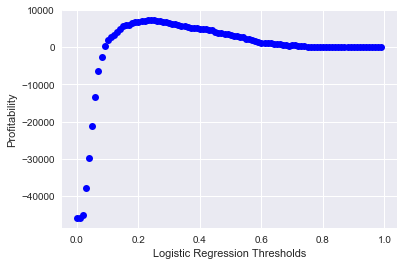

In [77]:
test_logistic_regression(X_train, X_validate, Y_train, Y_validate)

#### Regularization on unbalanced LR model & maximum achievable profitability 

In [78]:
def regularization_lr(X_train, X_validate, Y_train, Y_validate):
    param_grid = [0.001, 0.1, 1, 10,100]
    for param in param_grid:
        clf = LogisticRegression(C=param)
        clf.fit(X_train,Y_train)
        Y_proba = [x[1] for x in clf.predict_proba(X_validate)]
        threshold = np.arange(0.0,1.1,0.01)
        max_profitability = 0
        for t in threshold:
            Y_predict = 0
            Y_predict = np.where(Y_proba >= t ,1,Y_predict)
            tn,fp,fn,tp = confusion_matrix(Y_validate,Y_predict).ravel()
            principal_amt = 1000
            profitability = ((tp*.043*principal_amt))-((tp+fp)*11)
            if profitability > max_profitability: 
                max_profitability = profitability
                max_threshold = t
                max_C = param
    print ('Regularization coefficient C at which profitability is maximum is:',param)
    print ('Threshold at which profitability is the highest is:',max_threshold)
    print ('Maximum achievable profitability with the model is:',max_profitability)
    print ('ROC AUC:',format(roc_auc_score(Y_validate, Y_proba)))

In [79]:
regularization_lr(X_train, X_validate, Y_train, Y_validate)

Regularization coefficient C at which profitability is maximum is: 100
Threshold at which profitability is the highest is: 0.25
Maximum achievable profitability with the model is: 7230.0
ROC AUC: 0.7752617994820137


In [80]:
# Profitability on Test data with regularization
def profitability(clf,X_train,X_test,Y_train,Y_test):
    #lr = LogisticRegression(C=100)
    clf.fit(X_train, Y_train)
    Y_predict = clf.predict(X_test)
    Y_proba = [x[1] for x in clf.predict_proba(X_test)]
    threshold = np.arange(0.0,1,0.01)
    max_profitability = 0
    for t in threshold:
        Y_predict = 0
        Y_predict = np.where(Y_proba >= t ,1,Y_predict)
        tn,fp,fn,tp = confusion_matrix(Y_test,Y_predict).ravel()
        principal_amt = 1000
        profitability = ((tp*.043*principal_amt))-((tp+fp)*11)
        if profitability > max_profitability: 
                max_profitability = profitability
                max_threshold = t
                
        plt.plot(t,profitability,'bo')        
        plt.xlabel('Probability Thresholds')
        plt.ylabel('Profitability')
        plt.grid(True)
                
    print ('Threshold at which profitability is the highest is:',max_threshold)
    print ('Maximum achievable profitability with the model is:',max_profitability)
    print ('ROC AUC:',format(roc_auc_score(Y_test, Y_proba)))

Threshold at which profitability is the highest is: 0.22
Maximum achievable profitability with the model is: 10963.0
ROC AUC: 0.7801769864993303


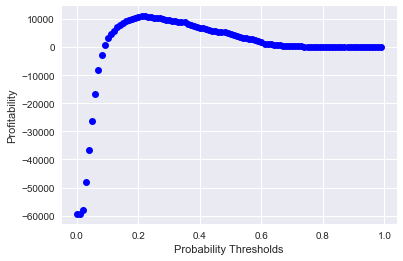

In [81]:
profitability(LogisticRegression(C=100),X_train,X_test,Y_train,Y_test)

### Model 1 B - Logistic Regression on Resampled data and testing on hold-out test set

#### Up-sampling the training dataset

In [82]:
from sklearn.utils import resample

# Splitting majority and minority class sets
bank_maj = train_validate_XY[train_validate_XY.outcome==0] # Majority class
bank_min = train_validate_XY[train_validate_XY.outcome==1] # Minority class

#upsampling minority class 
bank_min_upsmpl = resample(bank_min, 
                                 replace=True, # sample with replacement
                                 n_samples=len(bank_maj),  # to match majority class size
                                 random_state=123) # reproducible results
bank_upsmpl = pd.concat([bank_maj, bank_min_upsmpl])
upsmpl_y = bank_upsmpl.outcome
upsmpl_x = bank_upsmpl.drop('outcome', axis=1)

#### Down-sampling the training dataset

In [83]:
# Splitting majority and minority class sets
bank_maj = train_validate_XY[train_validate_XY.outcome==0] # Majority class
bank_min = train_validate_XY[train_validate_XY.outcome==1] # Minority class

#downsampling majority class
bank_maj_downsmpl = resample(bank_maj, 
                                 replace=False,     # sample without replacement
                                 n_samples=len(bank_min),    # to match minority class size
                                 random_state=123) # reproducible results
bank_downsmpl = pd.concat([bank_min, bank_maj_downsmpl])
downsmpl_y = bank_downsmpl.outcome
downsmpl_x = bank_downsmpl.drop('outcome', axis=1)

#### Regualrization and maximum profitability from upsampling & downsampling data

Threshold at which profitability is the highest is: 0.68
Maximum achievable profitability with the model is: 10806.0
ROC AUC: 0.7837297012963611


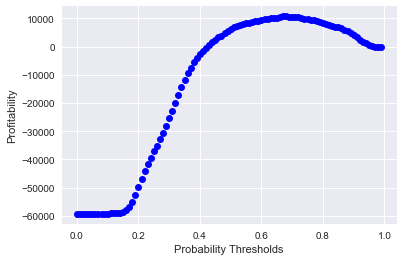

In [84]:
# Profitabilty with upsampling
profitability(LogisticRegression(C=100),upsmpl_x,X_test,upsmpl_y,Y_test)

Threshold at which profitability is the highest is: 0.69
Maximum achievable profitability with the model is: 10697.0
ROC AUC: 0.7808918135628553


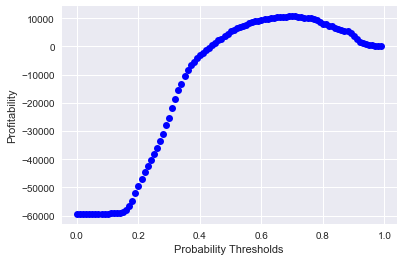

In [85]:
# Profitabilty with downsampling
profitability(LogisticRegression(C=100),downsmpl_x,X_test,downsmpl_y,Y_test)

Dataset rebalancing has not proven to be effective in our business case. There was no improvement in either profitability or ROC AUC.

## Model 2 - Random Forest Classifier

In [86]:
# Importing Random Forest Classifier from library
from sklearn.ensemble import RandomForestClassifier

In [87]:
def regularization_rfc(X_train, X_validate, Y_train,Y_validate):
    results = pd.DataFrame()
    leaf_size = [5,10,50,100]
    estimators = [10,50,100]
    split_size = [2,5,10]
    for leaf in leaf_size:
        for estimator in estimators:
            for split in split_size:
                clf = RandomForestClassifier(min_samples_leaf = leaf,min_samples_split = split, n_estimators = estimator)
                clf.fit(X_train,Y_train)
                Y_proba = [x[1] for x in clf.predict_proba(X_validate)]
                threshold = np.arange(0.0,1.0,0.01)
                max_profitability = 0
                for t in threshold:
                    Y_predict = 0
                    Y_predict = np.where(Y_proba >= t ,1,Y_predict)
                    tn,fp,fn,tp = confusion_matrix(Y_validate,Y_predict).ravel()
                    principal_amt = 1000
                    profitability = ((tp*.043*principal_amt))-((tp+fp)*11)
                   
                    results = results.append({'Threshold':t,'leaf_size': leaf, 'Estimator': estimator, 'split_size': split,'Profitability': profitability},ignore_index = True)
    return results.sort_values(by=['Profitability'], ascending=False).head(5)

In [88]:
regularization_rfc(X_train, X_validate, Y_train,Y_validate)

,Estimator,Profitability,Threshold,leaf_size,split_size
1229,50.0,7283.0,0.29,10.0,2.0
927,10.0,7269.0,0.27,10.0,2.0
925,10.0,7268.0,0.25,10.0,2.0
926,10.0,7251.0,0.26,10.0,2.0
1230,50.0,7245.0,0.30,10.0,2.0


Threshold at which profitability is the highest is: 0.23
Maximum achievable profitability with the model is: 11164.0
ROC AUC: 0.7928689761962809


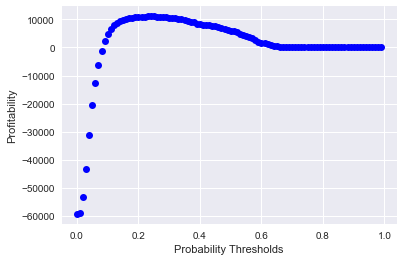

In [90]:
profitability(RandomForestClassifier(min_samples_leaf = 10,min_samples_split = 2, n_estimators = 50),X_train, X_test, Y_train,Y_test)

## Model 3 - Support Vector Machines

In [91]:
# Importing svm from library
from sklearn import svm

In [92]:
def regularization_svm(X_train, X_validate, Y_train, Y_validate):
    results = pd.DataFrame()
    Cs = [0.01,0.1,1]
    gammas = [1,10]
    for i in Cs:
        for j in gammas:
                clf = svm.SVC(C = i, gamma = j,probability=True)
                clf.fit(X_train,Y_train)
                Y_proba = [x[1] for x in clf.predict_proba(X_validate)]
                threshold = np.arange(0.0,1.0,0.01)
                for t in threshold:
                    Y_predict = 0
                    Y_predict = np.where(Y_proba >= t ,1,Y_predict)
                    tn,fp,fn,tp = confusion_matrix(Y_validate,Y_predict).ravel()
                    principal_amt = 1000
                    profitability = ((tp*.043*principal_amt))-((tp+fp)*11)
                   
                    results = results.append({'Threshold':t,'Cs': i, 'Gammas': j,'Profitability': profitability},ignore_index = True)
    return results.sort_values(by=['Profitability'], ascending=False).head(5)

In [ ]:
# SVM grid search results
#regularization_svm(X_train, X_validate, Y_train, Y_validate)

Threshold at which profitability is the highest is: 0.4
Maximum achievable profitability with the model is: 904.0
ROC AUC: 0.6737046878698905


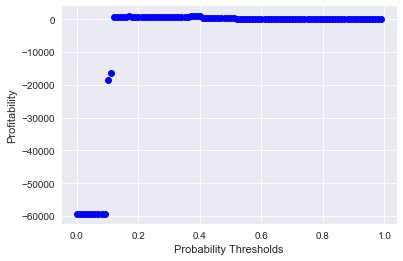

In [93]:
profitability(svm.SVC(kernel = 'rbf',C=1, gamma = 10, probability=True),X_train, X_test, Y_train,Y_test)

Threshold at which profitability is the highest is: 0.1
Maximum achievable profitability with the model is: 8039.0
ROC AUC: 0.6845418150645001


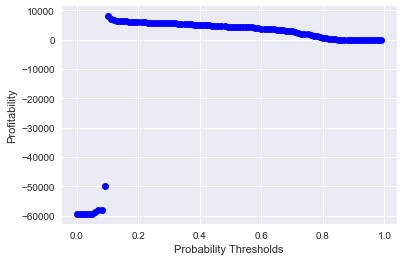

In [94]:
# kernel = rbf(default), C = 1, gamma = auto
profitability(svm.SVC(kernel = 'rbf',gamma = 'auto',C=1,probability=True),X_train, X_test, Y_train,Y_test)

Threshold at which profitability is the highest is: 0.1
Maximum achievable profitability with the model is: 8147.0
ROC AUC: 0.687677933860499


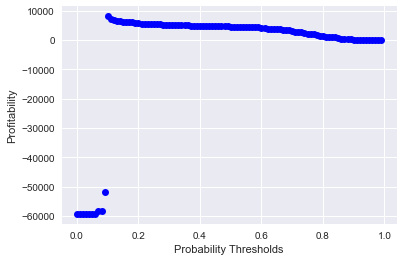

In [95]:
profitability(svm.SVC(kernel= 'rbf',gamma = 'auto',C=0.1, probability=True),X_train, X_test, Y_train,Y_test)

Threshold at which profitability is the highest is: 0.11
Maximum achievable profitability with the model is: 322.0
ROC AUC: 0.5800388793490282


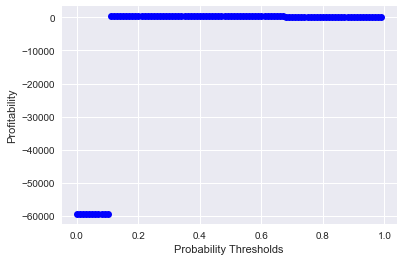

In [97]:
profitability(svm.SVC(kernel='linear',C=1,probability=True),X_train, X_test, Y_train,Y_test)

Threshold at which profitability is the highest is: 0.11
Maximum achievable profitability with the model is: 322.0
ROC AUC: 0.6701169162930222


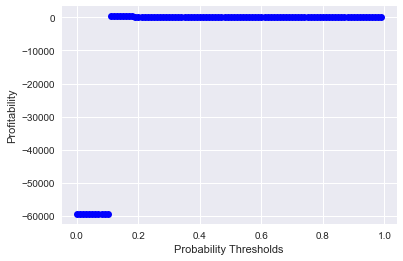

In [98]:
profitability(svm.SVC(kernel='linear',C=0.1,probability=True),X_train, X_test, Y_train,Y_test)

Threshold at which profitability is the highest is: 0.11
Maximum achievable profitability with the model is: 322.0
ROC AUC: 0.5602691742367228


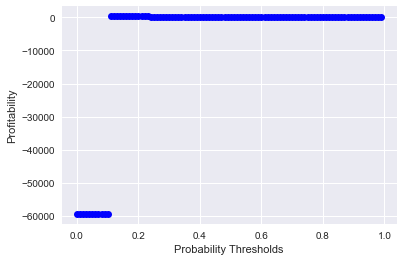

In [99]:
profitability(svm.SVC(kernel='linear',C=0.01,probability=True),X_train, X_test, Y_train,Y_test)

## Conclusion

Baseline profitability i.e performance of the original campaign stood at (- $ 254,709). By incorporating predictive analysis through machine learning algorithms there has been a drastic improvement in outcome predictions thereby providing a multi-fold increase in profitability.

Random Forests turned out to be the best model of the three machine learning models used in our analysis. It provided an increase in profitability by ~104% over baseline model providing campaign profits of $ 11,164 to the marketing team. 
